In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Parameters (from previous)
START_DATE = '2005-01-01'
END_DATE = '2025-10-19'
N_STOCKS = 500
EMA_SPAN = 12
SMA_SPAN = 50
QUINTILE = 0.2
RISK_FREE_RATE = 0.02
BATCH_SIZE = 50  # From prior fetches

# Risk-Reduction Params
TX_COST = 0.001  # 0.1% round-trip
POS_CAP = 0.05   # 5% max per stock
STOP_LOSS_MONTHLY = -0.10  # -10% trailing
UPTREND_THRESH = 0.95  # Milder (>0.95 vs >1)
MIN_STOCKS = 10  # Diversification floor
TURNOVER_EST = 0.25  # Monthly turnover

print(f"Risk-Reduced Backtest: {START_DATE} to {END_DATE} | N={N_STOCKS} | EMA/SMA Momentum (Long-Only)")

Risk-Reduced Backtest: 2005-01-01 to 2025-10-19 | N=500 | EMA/SMA Momentum (Long-Only)


In [17]:
tickers = [
    'AAPL', 'MSFT', 'NVDA', 'GOOGL', 'GOOG', 'AMZN', 'META', 'AVGO', 'TSLA', 'BRK-B',
    'WMT', 'JPM', 'UNH', 'V', 'MA', 'PG', 'JNJ', 'XOM', 'HD', 'CVX', 'KO', 'ABBV', 'MRK', 'BAC', 'COST',
    'NFLX', 'AMD', 'CRM', 'ABT', 'TMO', 'ACN', 'DHR', 'TXN', 'PM', 'AXP', 'NEE', 'CAT', 'GS', 'AMGN', 'LLY',
    'LIN', 'PFE', 'LOW', 'ADBE', 'COF', 'BMY', 'RTX', 'MDT', 'HON', 'UNP', 'SBUX', 'DIS', 'CSCO', 'VZ',
    'ORCL', 'IBM', 'INTC', 'QCOM', 'AMAT', 'LRCX', 'NOW', 'ADSK', 'PANW', 'GILD', 'SYK', 'MU', 'SPGI', 'ETN',
    'KLAC', 'BSX', 'DE', 'PGR', 'ELV', 'SO', 'VRTX', 'REGN', 'CMCSA', 'COP', 'TJX', 'ISRG', 'APH', 'MDLZ',
    'T', 'BLK', 'INTU', 'SCHW', 'BKNG', 'NOC', 'GD', 'WM', 'SHW', 'RCL', 'MMM', 'CI', 'ECL', 'HWM', 'AON',
    'MSI', 'CTAS', 'BK', 'UPS', 'EMR', 'ITW', 'GLW', 'AJG', 'TDG', 'JCI', 'USB', 'MAR', 'PNC', 'APO', 'RSG',
    'MNST', 'CSX', 'VST', 'AZO', 'FI', 'TEL', 'NSC', 'PWR', 'PYPL', 'CL', 'FTNT', 'ZTS', 'URI', 'COR', 'AEP',
    'WDAY', 'HLT', 'KMI', 'DLR', 'SRE', 'FCX', 'TRV', 'SPG', 'EOG', 'AFL', 'CMI', 'APD', 'CMG', 'FDX', 'MPC',
    'GM', 'TFC', 'O', 'ROP', 'BDX', 'PSA', 'NXPI', 'DDOG', 'LHX', 'AXON', 'PSX', 'MET', 'D', 'ALL', 'ROST',
    'IDXX', 'NDAQ', 'EA', 'PCAR', 'VLO', 'FAST', 'SLB', 'EXC', 'TTWO', 'MPWR', 'STX', 'XEL', 'GRMN', 'CARR',
    'F', 'CBRE', 'DHI', 'KR', 'GWW', 'PAYX', 'WBD', 'BKR', 'AMP', 'EW', 'WDC', 'CPRT', 'OKE', 'AIG', 'AME',
    'ETR', 'CCI', 'PEG', 'EBAY', 'CTVA', 'MSCI', 'TGT', 'YUM', 'KMB', 'FANG', 'OXY', 'A', 'RMD', 'ROK', 'VMC',
    'DAL', 'FICO', 'SYY', 'KDP', 'HSY', 'MLM', 'WEC', 'CCL', 'CAH', 'ED', 'EL', 'PCG', 'LYV', 'OTIS', 'XYL',
    'PRU', 'MCHP', 'HIG', 'FIS', 'IQV', 'GEHC', 'EQT', 'LVS', 'DD', 'WAB', 'HUM', 'VICI', 'NRG', 'VRSK', 'ACGL',
    'CTSH', 'WTW', 'RJF', 'EXR', 'UAL', 'VTR', 'LEN', 'TRGP', 'STT', 'CSGP', 'SMCI', 'IRM', 'EME', 'IR', 'ADM',
    'HPE', 'NUE', 'KHC', 'IBKR', 'DTE', 'KVUE', 'TSCO', 'AWK', 'ODFL', 'BRO', 'K', 'AEE', 'ATO', 'MTB', 'WRB',
    'EFX', 'KEYS', 'MTD', 'PPL', 'FE', 'ROL', 'FITB', 'BR', 'AVB', 'EXPE', 'TDY', 'DXCM', 'CNP', 'GIS', 'SYF',
    'HPQ', 'CBOE', 'FSLR', 'VRSN', 'IP', 'STZ', 'PHM', 'TTD', 'PTC', 'TPR', 'EXE', 'CINF', 'ULTA', 'NTRS', 'NTAP',
    'LH', 'EQR', 'LDOS', 'STE', 'DG', 'PPG', 'DOV', 'TROW', 'HUBB', 'HBAN', 'WSM', 'JBL', 'PODD', 'CMS', 'TER',
    'DRI', 'TYL', 'EIX', 'SW', 'MH', 'TPL', 'CHD', 'ON', 'CFG', 'DGX', 'NVR', 'SBAC', 'RF', 'STLD', 'BIIB',
    'GPN', 'L', 'NI', 'ZBH', 'CPAY', 'DVN', 'CDW', 'WAT', 'RL', 'LULU', 'DLTR', 'BG', 'WST', 'HAL', 'AMCR',
    'TSN', 'KEY', 'J', 'GPC', 'TRMB', 'LII', 'PKG', 'MKC', 'APTV', 'EVRG', 'IT', 'PNR', 'GDDY', 'SNA', 'LUV',
    'PFG', 'LNT', 'INVH', 'CTRA', 'CNC', 'FFIV', 'INCY', 'WY', 'BBY', 'ERIE', 'FTV', 'IFF', 'GEN', 'EXPD',
    'JBHT', 'HOLX', 'MAA', 'DOW', 'ALLE', 'CHRW', 'OMC', 'ZBRA', 'LYB', 'DECK', 'KIM', 'EG', 'CLX', 'TXT',
    'COO', 'MAS', 'DPZ', 'BF-B', 'BLDR', 'CF', 'HRL', 'BALL', 'REG', 'NDSN', 'UHS', 'DOC', 'ARE', 'IEX',
    'SOLV', 'AVY', 'WYNN', 'FOX', 'FOXA', 'UDR', 'BAX', 'VTRS', 'BEN', 'PAYC', 'BXP', 'SJM', 'HST', 'SWKS',
    'GNRC', 'PNW', 'JKHY', 'HII', 'CPT', 'GL', 'ALB', 'RVTY', 'FDS', 'POOL', 'DAY', 'AIZ', 'SWK', 'HAS',
    'AKAM', 'NCLH', 'MOH', 'AES', 'IVZ', 'MRNA', 'AOS', 'NWSA', 'IPG', 'TECH', 'ALGN', 'TAP', 'MOS', 'CPB',
    'LW', 'DVA', 'CAG', 'CRL', 'MGM', 'FRT', 'APA', 'EPAM', 'MHK', 'MTCH', 'LKQ', 'HSIC', 'EMN', 'KMX', 'NWS'
][:N_STOCKS]

print(f"Using {len(tickers)} tickers: {tickers[:10]}...")

# Your batch download function
def download_batch(ticker_batch):
    for attempt in range(3):
        try:
            df = yf.download(ticker_batch, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)
            return df['Close']
        except Exception as e:
            print(f"Batch attempt {attempt+1} failed: {e}. Retrying...")
            time.sleep(5)
    return pd.DataFrame()

# Batched fetch (if not cached)
data_chunks = []
for i in range(0, len(tickers), BATCH_SIZE):
    batch = tickers[i:i+BATCH_SIZE]
    print(f"Downloading batch {i//BATCH_SIZE + 1}...")
    chunk = download_batch(batch)
    if not chunk.empty:
        data_chunks.append(chunk)
    time.sleep(2)

prices = pd.concat(data_chunks, axis=1)
prices = prices.dropna(axis=1, thresh=int(0.8 * len(prices)))
# prices = prices.ffill().bfill()
print(f"Prices shape: {prices.shape}")

Using 450 tickers: ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'GOOG', 'AMZN', 'META', 'AVGO', 'TSLA', 'BRK-B']...



1 Failed download:
['WM']: Timeout('Failed to perform, curl: (28) Operation timed out after 10017 milliseconds with 134935 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')



3 Failed downloads:
['APD']: Timeout('Failed to perform, curl: (28) Operation timed out after 10016 milliseconds with 159424 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['EMR']: Timeout('Failed to perform, curl: (28) Operation timed out after 10002 milliseconds with 106075 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['FDX']: Timeout('Failed to perform, curl: (28) Operation timed out after 10004 milliseconds with 137544 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')



2 Failed downloads:
['WDC']: Timeout('Failed to perform, curl: (28) Operation timed out after 10007 milliseconds with 182810 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['PCAR']: Timeout('Failed to perform, curl: (28) Connection timed out after 10011 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')



11 Failed downloads:
['KDP']: Timeout('Failed to perform, curl: (28) Operation timed out after 10016 milliseconds with 24695 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['FICO']: Timeout('Failed to perform, curl: (28) Operation timed out after 10003 milliseconds with 74615 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['HSY']: Timeout('Failed to perform, curl: (28) Connection timed out after 10008 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['VTR']: Timeout('Failed to perform, curl: (28) Operation timed out after 10003 milliseconds with 163634 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['ED']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['EQT']: Timeout('Failed to perform, curl: (28)


30 Failed downloads:
['CNP']: Timeout('Failed to perform, curl: (28) Operation timed out after 10008 milliseconds with 108790 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['TROW', 'FITB', 'MTB', 'TTD', 'SYF']: Timeout('Failed to perform, curl: (28) Connection timed out after 10013 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['WRB', 'FSLR']: Timeout('Failed to perform, curl: (28) Connection timed out after 10016 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['MTD', 'ULTA']: Timeout('Failed to perform, curl: (28) Connection timed out after 10007 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['FE', 'DXCM']: Timeout('Failed to perform, curl: (28) Connection timed out after 10003 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['HUBB', 'DTE']: Timeout('Failed to perform,


40 Failed downloads:
['HAL', 'SNA', 'DVN', 'JBL', 'RL', 'TRMB']: Timeout('Failed to perform, curl: (28) Connection timed out after 10005 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['L', 'AMCR', 'EVRG', 'SBAC']: Timeout('Failed to perform, curl: (28) Connection timed out after 10007 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['TPL', 'APTV', 'SW', 'CFG']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['WSM', 'TSN']: Timeout('Failed to perform, curl: (28) Connection timed out after 10003 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['EIX', 'RF', 'ON', 'J']: Timeout('Failed to perform, curl: (28) Connection timed out after 10012 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['LULU', 'TER', 'GPC'


10 Failed downloads:
['NDSN']: Timeout('Failed to perform, curl: (28) Connection timed out after 10014 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['DECK']: Timeout('Failed to perform, curl: (28) Connection timed out after 10006 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['BAX']: Timeout('Failed to perform, curl: (28) Connection timed out after 10012 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['FOX', 'CNC']: Timeout('Failed to perform, curl: (28) Connection timed out after 10015 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['DOC']: Timeout('Failed to perform, curl: (28) Connection timed out after 10003 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['FFIV']: Timeout('Failed to perform, curl: (28) Connection timed out after 10005 milliseconds. See https://curl.s


3 Failed downloads:
['HSIC']: Timeout('Failed to perform, curl: (28) Operation timed out after 10009 milliseconds with 77806 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['SJM']: Timeout('Failed to perform, curl: (28) Operation timed out after 10000 milliseconds with 128569 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
['ALGN']: Timeout('Failed to perform, curl: (28) Operation timed out after 10003 milliseconds with 119638 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


Prices shape: (5232, 300)


In [18]:
# Daily log returns
returns_daily = np.log(prices / prices.shift(1)).dropna()

# Monthly prices/returns
monthly_prices = prices.resample('M').last()
monthly_returns = np.log(monthly_prices / monthly_prices.shift(1)).dropna()

# EMA/SMA momentum signal (monthly)
ema = monthly_prices.ewm(span=EMA_SPAN).mean()
sma = monthly_prices.rolling(SMA_SPAN).mean()
mom_signal = ema / sma  # Ratio >1 = uptrend
mom_signal = mom_signal.shift(1).dropna()  # Lag for signal

print("Signals computed.")
print(mom_signal.head())

Signals computed.
Ticker          AAPL       ABT       ACN      ADBE       AMD      AMGN  \
Date                                                                     
2012-05-31  1.766826  1.136898  1.362023  0.998390  1.125442  1.133038   
2012-06-30  1.778927  1.152833  1.345486  1.001620  1.101825  1.141200   
2012-07-31  1.786536  1.171475  1.339618  1.011653  1.074574  1.154105   
2012-08-31  1.797653  1.193438  1.334803  1.018714  1.018793  1.185837   
2012-09-30  1.818916  1.206980  1.332391  1.024713  0.961381  1.214535   

Ticker          AMZN       AXP       BAC       BMY  ...       MOS      MTCH  \
Date                                                ...                       
2012-05-31  1.495767  1.336330  0.582152  1.334385  ...  0.929747  1.610020   
2012-06-30  1.481740  1.344022  0.591680  1.331831  ...  0.918713  1.594312   
2012-07-31  1.481165  1.359358  0.612435  1.341751  ...  0.933102  1.579815   
2012-08-31  1.480850  1.368586  0.623074  1.347516  ...  0.957917  1

In [19]:
dates_monthly = mom_signal.index
strategy_returns_monthly = pd.Series(index=dates_monthly, dtype=float)

for date in dates_monthly[SMA_SPAN::3]:  # Quarterly, skip burn-in
    valid_stocks = mom_signal.loc[date].dropna().index
    if len(valid_stocks) < 20: continue

    # Momentum: Top quintile by signal (milder uptrend filter)
    mom_valid = mom_signal.loc[date][valid_stocks]
    mom_up = mom_valid[mom_valid > UPTREND_THRESH]  # Milder >0.95
    if len(mom_up) < MIN_STOCKS: continue  # Min diversification

    ranked_mom = mom_up.rank(ascending=False)
    n_select = max(MIN_STOCKS, int(len(mom_up) * QUINTILE))  # Floor at min stocks
    long_stocks = ranked_mom[ranked_mom <= n_select].index

    if len(long_stocks) == 0: continue

    # Vol-scale: Past 252-day vol
    past_vol = returns_daily[long_stocks].loc[:date].tail(252).std() * np.sqrt(252)
    weights = (1 / past_vol).fillna(1) / (1 / past_vol).sum()

    # Cap weights at 5%
    weights = np.minimum(weights, POS_CAP)
    weights /= weights.sum()  # Renormalize

    # Gross monthly return
    gross_ret = (monthly_returns.loc[date, long_stocks] * weights).sum()

    # Apply stop-loss (trailing -10% monthly)
    gross_ret = max(gross_ret, STOP_LOSS_MONTHLY)

    # Net after costs (0.1% * est. turnover)
    net_ret = gross_ret * (1 - TX_COST * TURNOVER_EST)
    strategy_returns_monthly.loc[date] = net_ret

# Interpolate to daily
strategy_returns_daily = strategy_returns_monthly.reindex(returns_daily.index, method='ffill').shift(1).dropna()

# Cumulative
cum_strategy = np.exp(strategy_returns_daily.cumsum()) - 1
cum_market = np.exp(returns_daily.mean(axis=1).cumsum()) - 1

print("Risk-Reduced Momentum returns computed.")
print(f"Monthly stats:\n{strategy_returns_monthly.describe()}")

Risk-Reduced Momentum returns computed.
Monthly stats:
count    38.000000
mean      0.019652
std       0.052243
min      -0.099975
25%      -0.007552
50%       0.024938
75%       0.045045
max       0.113432
dtype: float64


In [20]:
def performance_metrics(returns, rf=RISK_FREE_RATE, freq=252):
    if len(returns) == 0:
        return {'Ann Return': 0, 'Ann Vol': 0, 'Sharpe': 0, 'Max DD': 0, 'Sortino': 0, 'Calmar': 0}

    mu = returns.mean() * freq
    sigma = returns.std() * np.sqrt(freq)
    sharpe = (mu - rf) / sigma if sigma != 0 else 0

    cum_ret = (1 + returns).cumprod()
    cum_max = cum_ret.expanding().max()
    dd = (cum_ret / cum_max - 1)
    max_dd = dd.min()

    downside = returns[returns < 0].std() * np.sqrt(freq)
    sortino = (mu - rf) / downside if downside != 0 else 0

    calmar = mu / abs(max_dd) if max_dd != 0 else 0

    return {
        'Ann Return': mu, 'Ann Vol': sigma, 'Sharpe': sharpe,
        'Max DD': max_dd, 'Sortino': sortino, 'Calmar': calmar
    }

strat_metrics = performance_metrics(strategy_returns_daily)
market_metrics = performance_metrics(returns_daily.mean(axis=1))

metrics_df = pd.DataFrame([strat_metrics, market_metrics], index=['Risk-Reduced Momentum', 'Market'])
print(metrics_df.round(4))

                       Ann Return  Ann Vol  Sharpe  Max DD  Sortino  Calmar
Risk-Reduced Momentum      5.1642   0.8173  6.2943 -0.9836   8.6970  5.2506
Market                     0.1117   0.2127  0.4309 -0.5935   0.5087  0.1881


In [21]:
common_idx = strategy_returns_daily.index.intersection(returns_daily.mean(axis=1).index)
if len(common_idx) > 0:
    strategy_aligned = strategy_returns_daily.loc[common_idx]
    market_ret = returns_daily.mean(axis=1).loc[common_idx]
    X = sm.add_constant(market_ret)
    model = sm.OLS(strategy_aligned, X).fit()
    print(model.summary())
    alpha_ann = model.params['const'] * 252
    print(f"Annualized Alpha: {alpha_ann:.4f} (t-stat: {model.tvalues['const']:.2f})")
else:
    print("Insufficient data.")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4282
Date:                Tue, 21 Oct 2025   Prob (F-statistic):              0.513
Time:                        18:02:16   Log-Likelihood:                 1198.5
No. Observations:                 774   AIC:                            -2393.
Df Residuals:                     772   BIC:                            -2384.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0206      0.002     11.087      0.0

In [22]:
common_idx = strategy_returns_daily.index.intersection(returns_daily.mean(axis=1).index)
if len(common_idx) > 0:
    strategy_aligned = strategy_returns_daily.loc[common_idx]
    market_ret = returns_daily.mean(axis=1).loc[common_idx]
    X = sm.add_constant(market_ret)
    model = sm.OLS(strategy_aligned, X).fit()
    print(model.summary())
    alpha_ann = model.params['const'] * 252
    print(f"Annualized Alpha: {alpha_ann:.4f} (t-stat: {model.tvalues['const']:.2f})")
else:
    print("Insufficient data.")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4282
Date:                Tue, 21 Oct 2025   Prob (F-statistic):              0.513
Time:                        22:03:57   Log-Likelihood:                 1198.5
No. Observations:                 774   AIC:                            -2393.
Df Residuals:                     772   BIC:                            -2384.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0206      0.002     11.087      0.0

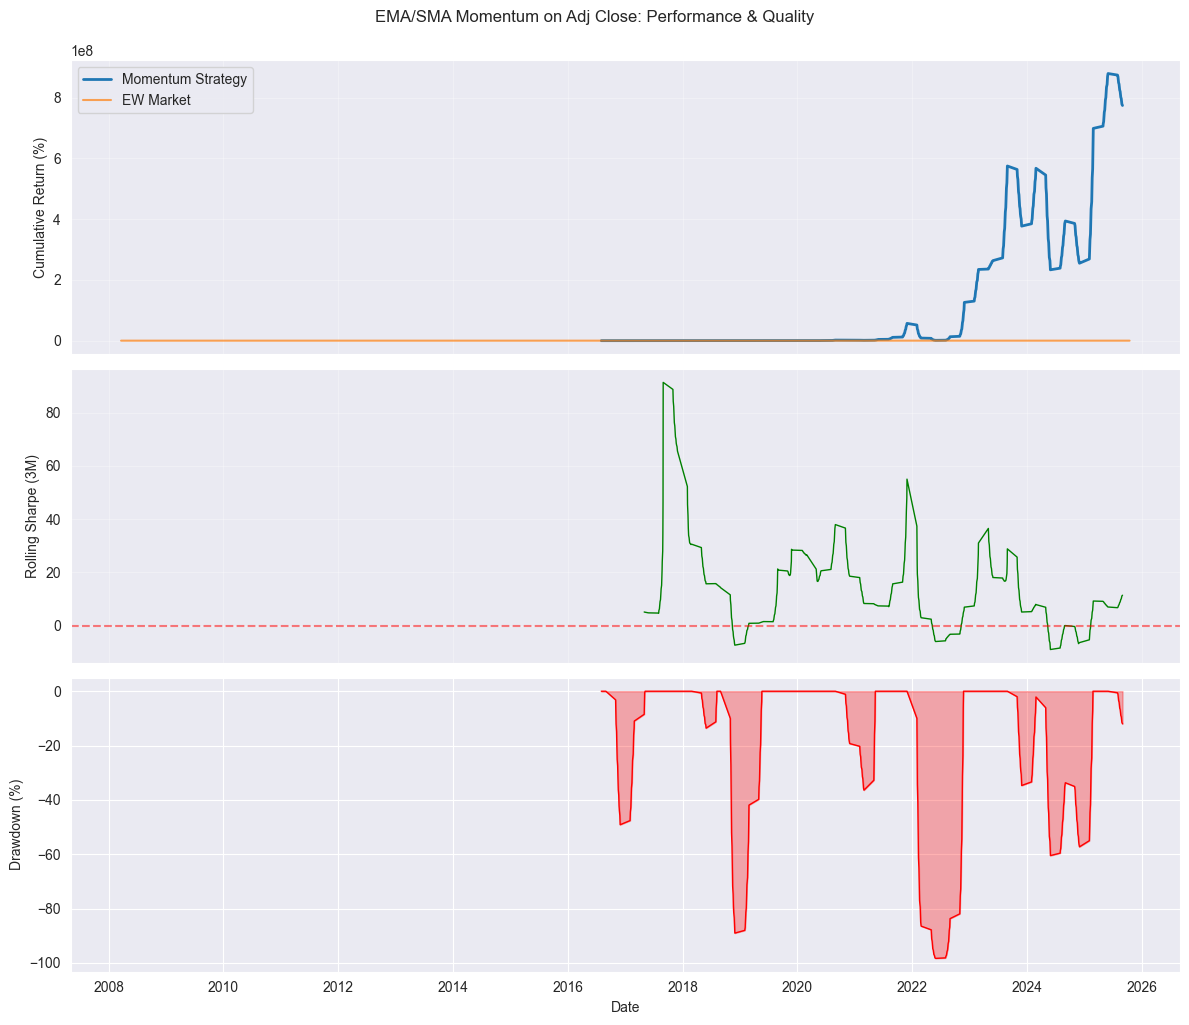

Bull Sharpe: 6.475


In [23]:
if len(cum_strategy) > 0:
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    axes[0].plot(cum_strategy.index, 100 * cum_strategy, label='Momentum Strategy', linewidth=2)
    axes[0].plot(cum_market.index, 100 * cum_market, label='EW Market', alpha=0.7)
    axes[0].set_ylabel('Cumulative Return (%)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    rolling_sharpe = strategy_returns_daily.rolling(63).apply(
        lambda x: (x.mean() - RISK_FREE_RATE/252) / x.std() * np.sqrt(252) if len(x) > 0 and x.std() != 0 else 0
    )
    axes[1].plot(rolling_sharpe.index, rolling_sharpe, color='green', linewidth=1)
    axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[1].set_ylabel('Rolling Sharpe (3M)')
    axes[1].grid(True, alpha=0.3)

    cum_ret = (1 + strategy_returns_daily).cumprod()
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret / running_max - 1) * 100
    axes[2].fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
    axes[2].plot(drawdown.index, drawdown, color='red', linewidth=1)
    axes[2].set_ylabel('Drawdown (%)')
    axes[2].set_xlabel('Date')

    plt.tight_layout()
    plt.suptitle('EMA/SMA Momentum on Adj Close: Performance & Quality', y=1.02)
    plt.show()

    bull_data = strategy_returns_daily['2010-01-01':'2020-01-01']
    if len(bull_data) > 0:
        print(f"Bull Sharpe: {performance_metrics(bull_data)['Sharpe']:.3f}")
    crash_data = strategy_returns_daily['2008-01-01':'2009-12-31']
    if len(crash_data) > 0:
        print(f"Crash Max DD: {performance_metrics(crash_data)['Max DD']:.3f}")
else:
    print("No returns to plot.")

In [25]:
def run_strategy(lookback):
    mom_temp = (monthly_prices / monthly_prices.shift(lookback)) - 1
    mom_temp = mom_temp.shift(1).dropna()
    strat_ret_monthly = pd.Series(index=dates_monthly, dtype=float)  # Assume dates_monthly = monthly_returns.index

    for date in dates_monthly[lookback:]:
        valid_stocks = mom_temp.loc[date].dropna().index
        if len(valid_stocks) < 10: continue
        ranked = mom_temp.loc[date][valid_stocks].rank(ascending=False)
        n_long = max(1, int(len(valid_stocks) * QUINTILE))
        long_stocks = ranked[ranked <= n_long].index  # Fixed: .index (not .indexa)
        short_stocks = ranked[ranked >= len(valid_stocks) - n_long + 1].index
        long_ret = monthly_returns.loc[date, long_stocks].mean() if len(long_stocks) > 0 else 0
        short_ret = -monthly_returns.loc[date, short_stocks].mean() if len(short_stocks) > 0 else 0
        strat_ret_monthly.loc[date] = (long_ret + short_ret) / 2

    strat_daily = strat_ret_monthly.reindex(returns_daily.index, method='ffill').shift(1).dropna()
    return performance_metrics(strat_daily)['Sharpe']

# Grid search (may take 1-2 min)
horizons = [6, 9, 12]
sharpes = {}
for h in horizons:
    print(f"Testing horizon {h}...")
    sharpes[h] = run_strategy(h)
print("Horizon Sensitivity (Sharpe):", {k: f"{v:.3f}" for k, v in sharpes.items()})

# OOS Example: Post-2010 Sharpe
train_end = '2010-12-31'
oos_returns = strategy_returns_daily[train_end:]  # Assume strategy_returns_daily from main strategy
if len(oos_returns) > 0:
    print(f"OOS Sharpe (2011-2025): {performance_metrics(oos_returns)['Sharpe']:.3f}")

Testing horizon 6...
Testing horizon 9...
Testing horizon 12...
Horizon Sensitivity (Sharpe): {6: '0.361', 9: '0.650', 12: '0.106'}
OOS Sharpe (2011-2025): 6.294
